# Programmatic Visualization

### Rendering movies to demonstrate scattering physics.

Colin Ophus (cophus@gmail.com) - 2024 Dec 30

This tutorial demonstrates how we can create a movie to demonstrate scattering physics of a scanning transmission electron microscopy (STEM) experiments.

Packages used:

- numpy (handle numerical arrays)
- matplotlib (most common python plotting library)
- matplotlib.cm (the colormaps from matplotlib)
- h5py (read and write hdf5 files)
- tqdm (progress bar)
- scipy.ndimage.gaussian_filter (gaussian filtering for 2D images)

The output figure / movie from this tutorial are inspired by the figures in my review articles:

[Quantitative STEM for materials science: imaging, diffraction, spectroscopy, and tomography](https://doi.org/10.1146/annurev-matsci-080921-092646)

[4D-STEM: from scanning nanodiffraction to ptychography and beyond](https://doi.org/10.1017/S1431927619000497)

We also want to acknowledge help from Steven Zeltmann on rendering and exporting movies directly from notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

### Create a static 3D scene of atoms

First, we will generate a set of 3D atomic coordinates for a polycrystalline sample.

In [2]:
# Define a function for generated 3D rotation matrices
def rot(
    theta,
    axis = 0,
    ):
    ct = np.cos(theta)
    st = np.sin(theta)
    if axis == 0:
        m = np.array([[1,0,0],[0,ct,-st],[0,st,ct]])
    elif axis == 1:
        m = np.array([[ct,0,st],[0,1,0],[-st,0,ct]])
    elif axis == 2:
        m = np.array([[ct,-st,0],[st,ct,0],[0,0,1]])
    return m

In [3]:
# fcc atoms
a_lattice = 4
basis = np.array([
    [0.25,0.25,0.25],
    [0.75,0.75,0.25],
    [0.75,0.25,0.75],
    [0.25,0.75,0.75],
]).T

# cell boundaries and other geometric variables
cell_dim = np.array((150,40,40))
tile_radius = 10
# data - (x,y,z) positions, (z,x,z) rotation
data_atoms = np.array([
    [-50, -4, -16,    0, 0, 76],
    [  0, 4, 20,    0,45,110],
    [ 50, 0, 2,    45,-54.73,22],
])

data_atoms[:,3:6] = np.deg2rad(data_atoms[:,3:6])

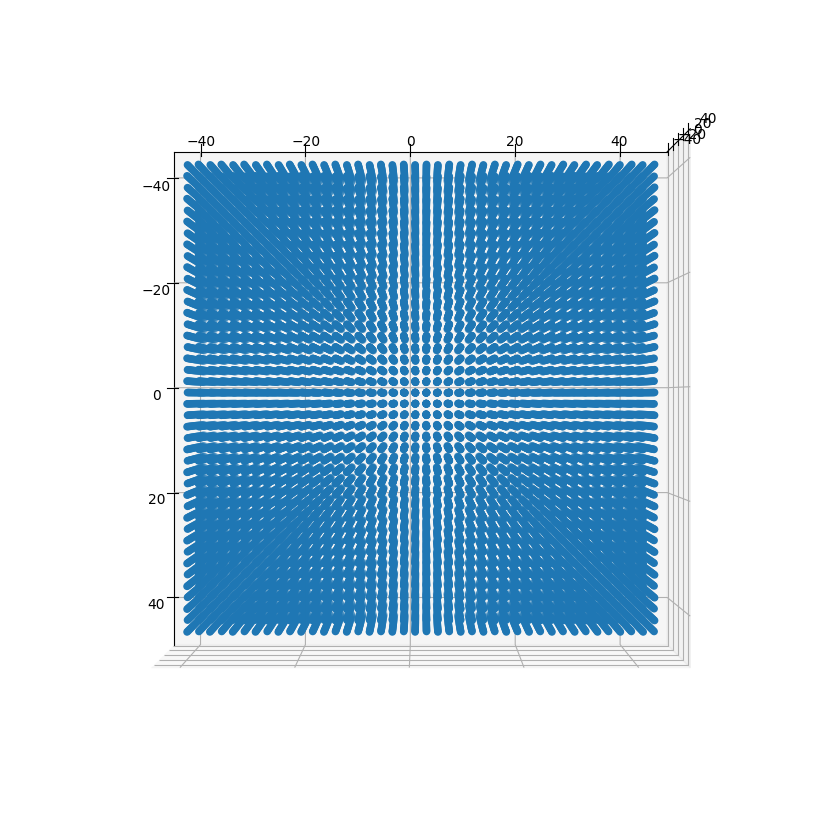

In [4]:
# Generate the initial set of atomic coordinates.
# We will rotate and crop this set of coordinates to make the sample.

r = np.arange(-tile_radius,tile_radius+1)
xa,ya,za,basis_id = np.meshgrid(
    r,r,r,
    np.arange(basis.shape[0]+1),
    indexing = 'ij',
)

xyz_init = (basis[:,basis_id.ravel()] + \
    np.vstack((
        xa.ravel(),
        ya.ravel(),
        za.ravel(),
    ))) * a_lattice

fig = plt.figure(
    figsize = (8,8),
)
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)
ax.scatter(
    xyz_init[0],
    xyz_init[1],
    xyz_init[2],
)
ax.view_init(
    elev = 90,
    azim = 0,
    roll = 0,
)

In [5]:
# Construct the unified set of coordinates

xyz_0 = np.vstack((
    rot(data_atoms[0,5],2) @ \
    rot(data_atoms[0,4],0) @ \
    rot(data_atoms[0,3],2) @ \
    xyz_init + data_atoms[0,0:3][:,None],
    np.ones(xyz_init.shape[1]) * 0,
))

xyz_1 = np.vstack((
    rot(data_atoms[1,5],2) @ \
    rot(data_atoms[1,4],0) @ \
    rot(data_atoms[1,3],2) @ \
    xyz_init + data_atoms[1,0:3][:,None],
    np.ones(xyz_init.shape[1]) * 1,
))

xyz_2 = np.vstack((
    rot(data_atoms[2,5],2) @ \
    rot(data_atoms[2,4],0) @ \
    rot(data_atoms[2,3],2) @ \
    xyz_init + data_atoms[2,0:3][:,None],
    np.ones(xyz_init.shape[1]) * 2,
))

In [6]:
# Combine the set of coordinates by cropping each set, then merging them

vec_01 = data_atoms[1,0:3] - data_atoms[0,0:3]
vec_12 = data_atoms[2,0:3] - data_atoms[1,0:3]
vec_01 /= np.linalg.norm(vec_01)
vec_12 /= np.linalg.norm(vec_12)
p_01 = (data_atoms[1,0:3] + data_atoms[0,0:3])/2.0
p_12 = (data_atoms[2,0:3] + data_atoms[1,0:3])/2.0

keep_0 = np.logical_and.reduce((
    vec_01 @ (xyz_0[:3,:]-p_01[:,None]) < -a_lattice/4.0,
    xyz_0[0,:] > -cell_dim[0]/2.0,
    xyz_0[1,:] > -cell_dim[1]/2.0,
    xyz_0[2,:] > -cell_dim[2]/2.0,
    xyz_0[0,:] <  cell_dim[0]/2.0,
    xyz_0[1,:] <  cell_dim[1]/2.0,
    xyz_0[2,:] <  cell_dim[2]/2.0,
))
keep_1 = np.logical_and.reduce((
    vec_01 @ (xyz_1[:3,:]-p_01[:,None]) > a_lattice/4.0,
    vec_12 @ (xyz_1[:3,:]-p_12[:,None]) < -a_lattice/4.0,
    xyz_1[0,:] > -cell_dim[0]/2.0,
    xyz_1[1,:] > -cell_dim[1]/2.0,
    xyz_1[2,:] > -cell_dim[2]/2.0,
    xyz_1[0,:] <  cell_dim[0]/2.0,
    xyz_1[1,:] <  cell_dim[1]/2.0,
    xyz_1[2,:] <  cell_dim[2]/2.0,
))
keep_2 = np.logical_and.reduce((
    vec_12 @ (xyz_2[:3,:]-p_12[:,None]) > a_lattice/4.0,
    xyz_2[0,:] > -cell_dim[0]/2.0,
    xyz_2[1,:] > -cell_dim[1]/2.0,
    xyz_2[2,:] > -cell_dim[2]/2.0,
    xyz_2[0,:] <  cell_dim[0]/2.0,
    xyz_2[1,:] <  cell_dim[1]/2.0,
    xyz_2[2,:] <  cell_dim[2]/2.0,
))

xyz_id = np.hstack((
    xyz_0[:,keep_0],
    xyz_1[:,keep_1],
    xyz_2[:,keep_2],
))


### Plot atomic coordinates

We will make a function to plot the atomic coordinates.  Later we will add more plotting components.

In [7]:
# As mentioned before, matplotlib does not plot objects in true 3D.
# This means that seemingly simple tasks like setting the (x,y,z) aspect ratios
# to 1 are surprisingly difficult to achieve in matplotlib. The below solution
# can fix this issue.

def set_axes_equal(ax: plt.Axes):
    # Set 3D plot axes to equal scale.
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

In [8]:
def plot_atoms(
    xyz_id,
    elev = 30,
    azim = 0,
    ):

    # parent colors for the 3 site types
    c_0 = np.array((1.0, 0.1, 0.0))
    c_1 = np.array((0.0, 0.8, 1.0))
    c_2 = np.array((1.0, 0.7, 0.0))
    c_t = np.array((1.0, 1.0, 1.0))

    # Depth cueing variables
    bg_color = np.array((0.0,0.0,0.0))
    bg_power_law = 1.5
    bg_scale = 0.5
    cam_pos = np.array((0.0,5.0,0.0)) * 1000

    # plotting code
    # Get a vector of boolean values (True or False) for each site.
    sub_0 = xyz_id[3,:] == 0
    sub_1 = xyz_id[3,:] == 1
    sub_2 = xyz_id[3,:] == 2

    # We will modify our data structure so that instead of specifying the
    # (red,green,blue) values, we have a column for "shading" and a column for "tinting."
    data = np.array([
        [0.00,0.0,0.0, 0.00, 0.0, 100, 0.0],
        [0.05,0.0,0.1, 0.25, 0.0,  80, 0.0],
        [0.10,0.0,0.2, 0.50, 0.0,  60, 0.0],
        [0.15,0.0,0.3, 0.75, 0.0,  40, 0.0],
        [0.20,0.0,0.4, 1.00, 0.0,  20, 0.0],

        [0.25,0.0,0.5, 0.00, 1.0,  4, 0.0],
    ])
    num_atoms = xyz_id.shape[1]
    atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
    for a0 in range(data.shape[0]):
        inds = np.arange(num_atoms) + a0 * num_atoms
        atoms_rgb_size[0:3,inds] = xyz_id[0:3,:] + np.array(data[a0,0:3])[:,None]
        atoms_rgb_size[6,inds]   = np.array(data[a0,5])
        atoms_rgb_size[7,inds]   = np.array(data[a0,6])

        # New coloring logic
        c = (sub_0[None,:] * c_0[:,None]) * data[a0,3] + \
            (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
            (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
            c_t[:,None] * data[a0,4]
        atoms_rgb_size[3:6,inds] = c

    # Apply depth cueing
    dist = np.sqrt(np.sum((atoms_rgb_size[0:3,:] - cam_pos[:,None])**2,axis = 0))
    dist -= np.min(dist)
    dist /= np.max(dist)  # scale to be 0 to 1
    dist **= bg_power_law
    dist *= bg_scale
    atoms_rgb_size[3:6,:] = atoms_rgb_size[3:6,:] * (1-dist) + bg_color[:,None] * dist

    # plotting
    fig = plt.figure(
        figsize = (8,8),
    )
    ax = fig.add_axes(
        rect = (0,0,1,1),
        projection = '3d',
    )

    # atomic sites
    ax.scatter(
        atoms_rgb_size[1],
        atoms_rgb_size[0],
        atoms_rgb_size[2],
        c = atoms_rgb_size[3:6,:].T,
        s = atoms_rgb_size[6,:],
        linewidth = atoms_rgb_size[7,:],
        edgecolor = (0,0,0),
        alpha = 1.0,
    );

    # Plot appearance
    ax.axis('off');
    ax.view_init(
        elev = elev,
        azim = azim,
        roll = 0,
    )
    ax.set_proj_type(
        proj_type = 'persp',
        focal_length = 0.2,
    )
    ax.set_box_aspect(
        (1,1,1),
        zoom = 1.5,
    )
    set_axes_equal(ax)
    plt.show()


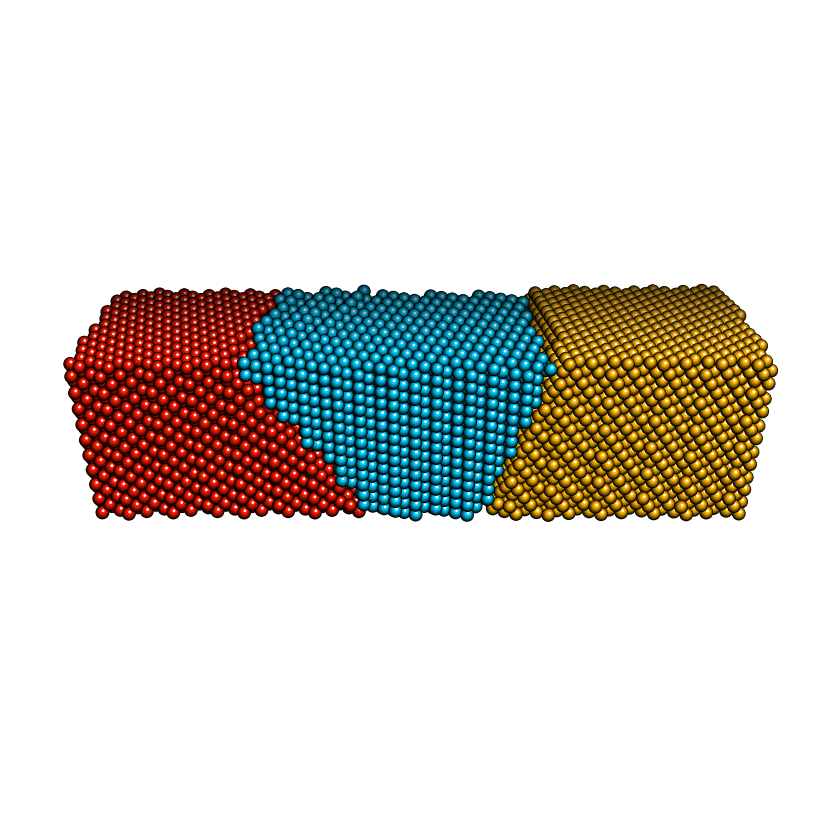

In [9]:
# Now let's try out the plotting function!
plot_atoms(xyz_id)

Looks pretty good!  This set of atomic coordinates will form the basis of our movie.

# Exercise 1 - Create your own set of atomic coordinates.

The above sample consists of three grains at different orientations, which were cropped to prevent overlap. In this exercise, you should create your own set of cordinates (i.e. your own version of 'xyz_id').  Some potential ideas:

- A single grain containing a twist, bend, or some similar distortion.
- A single grain which transitions from ordered to disordered.
- A polycrystalline sample with some form of texture, such as columnar grains.

In [10]:
# Answer 1

# Approximating diffraction patterns

A diffraction pattern is essentially a Fourier transform of the electron beam intensity distirbution multiplied by the same's projected potential.  If we have a converged electron beam, we can use the changing diffraction pattern to infer the sample structure.

In this section, we will calculate an approximation of these diffraction pattern signals as a function of probe position. To do this, we will project all of the atomic coordinates into an image, crop a section out, and then multply by a probe and take the Fourier transform.

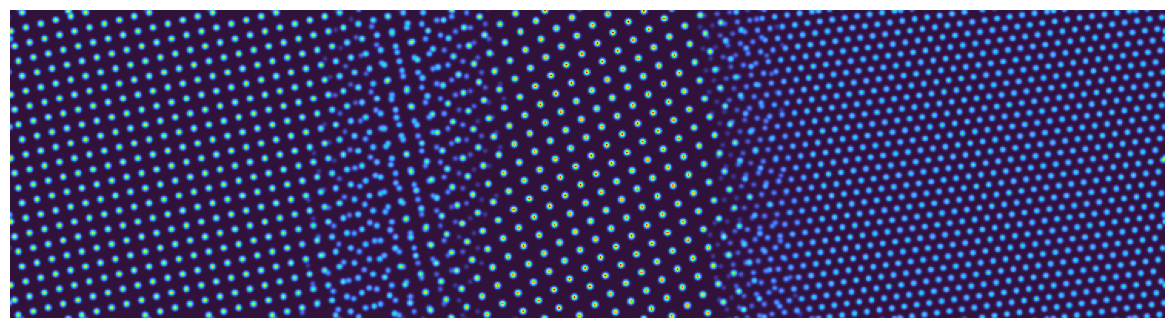

In [11]:
# First project all of the atomic coordinates into an image

pixel_size = 0.2  # relative to the earlier variable 'cell_dim'
sigma = 0.2   # blurring of atomic potentials in angstroms

# atom positions in pixels
im_shape = np.round(cell_dim[0:2] / pixel_size).astype('int')
im_size = np.prod(im_shape)
x_ind = xyz_id[0] / pixel_size + im_shape[0]//2
y_ind = xyz_id[1] / pixel_size + im_shape[1]//2

# bilinear interpolation
xf = np.floor(x_ind).astype('int')
yf = np.floor(y_ind).astype('int')
dx = x_ind - xf
dy = y_ind - yf
im_potential = np.reshape(
    np.bincount(
        np.mod(im_shape[1]*(xf+0) + (yf+0), im_size),
        weights = (1 - dx) * (1 - dy),
        minlength = im_size,
    ) + \
    np.bincount(
        np.mod(im_shape[1]*(xf+1) + (yf+0), im_size),
        weights = (    dx) * (1 - dy),
        minlength = im_size,
    ) + \
    np.bincount(
        np.mod(im_shape[1]*(xf+0) + (yf+1), im_size),
        weights = (1 - dx) * (    dy),
        minlength = im_size,
    ) + \
    np.bincount(
        np.mod(im_shape[1]*(xf+1) + (yf+1), im_size),
        weights = (    dx) * (    dy),
        minlength = im_size,
    ),
    im_shape,
)

# BLur out the atomic potentials
im_potential = gaussian_filter(
    im_potential,
    sigma = sigma / pixel_size,
    mode = 'wrap',
)


# plot the image
fig,ax = plt.subplots(figsize=(15,4))
ax.imshow(
    im_potential.T,
    cmap = 'turbo',
);
ax.axis('off');

We have a good atomic potential image - now let's create a function which performs these operations:
- crop potential image
- multiply by a probe signal
- take the FFT
- take the absolute magnitude, fft shift

In [12]:
def probe_image(
    im_potential,
    pixel_size,
    probe_xy = (0,0),   # in Angstroms
    probe_q_max = 0.15,
    crop_shape = (200,200),
    plot_output = False,
    ):

    # Generate initial probe image
    qx = np.fft.fftfreq(crop_shape[0], d = pixel_size)
    qy = np.fft.fftfreq(crop_shape[1], d = pixel_size)
    dq = qx[1] - qx[0]
    qr = np.sqrt(qx[:,None]**2 + qy[None,:]**2)
    probe_FFT = np.clip(
        (probe_q_max - qr)/dq + 0.5,
        0.0,
        1.0,
    )
    probe = np.fft.fftshift(
        np.fft.ifft2(probe_FFT),
    )

    # Crop out the subset of the potential image
    x = np.round(probe_xy[0] / pixel_size \
        + im_potential.shape[0]/2 \
        - crop_shape[0]/2) \
        + np.arange(crop_shape[0])
    y = np.round(probe_xy[1] / pixel_size \
        + im_potential.shape[1]/2 \
        - crop_shape[1]/2) \
        + np.arange(crop_shape[1])
    im_crop = im_potential[
        np.mod(x[:,None],im_potential.shape[0]).astype('int'),
        np.mod(y[None,:],im_potential.shape[1]).astype('int'),
    ]

    # Generate the (pseudo) diffraction pattern
    im_diff = np.fft.fftshift(
        np.abs(
            np.fft.fft2(
                im_crop * probe,
            ),
        ),
    )

    if plot_output:
        fig,ax = plt.subplots(figsize=(2,2))
        # ax.imshow(
        #     np.abs(probe)**0.25,
        # )
        ax.imshow(
            im_diff,
            cmap = 'gray',
        )
        ax.axis('off');

    return im_diff

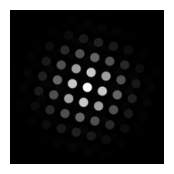

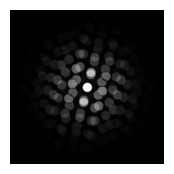

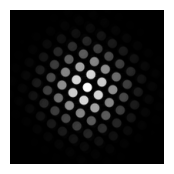

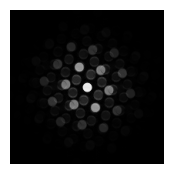

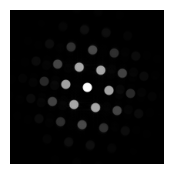

In [13]:
# Now let's test our function over the 3 grains, and at the boundaries
for px in (-50,-25,0,25,50):
    im_diff = probe_image(
        im_potential,
        pixel_size,
        probe_xy = (px,0),
        plot_output = True,
    )


# Exercise 2 - Diffraction from a complex electron probe

The above probe is defined fairly simply, as a circular aperture. Can you figure out how to numerically compute a more complex probe?  Specifically we'd like you to create a 'bullseye' probe, something like the probes shown in this paper:

https://arxiv.org/abs/1907.05504

In [14]:
# Answer 2

# Draw full scene

We now have all of the 'ingredients' for our physics movie - the atomic positions, and the ability to calculate diffraction patterns as function of probe position. We next need to update our plotting function to include passing in the probe position, and then draw each of the desired elements:
- atomic coordinates
- electron beam
- resulting diffraction patterns

In [15]:
def plot_scene(
    xyz_id,
    probe_xy = (0,0),
    elev = 30,
    azim = 0,
    ):

    # parent colors for the 3 site types
    c_0 = np.array((1.0, 0.1, 0.0))
    c_1 = np.array((0.0, 0.8, 1.0))
    c_2 = np.array((1.0, 0.7, 0.0))
    c_t = np.array((1.0, 1.0, 1.0))

    # Depth cueing variables
    bg_color = np.array((0.0,0.0,0.0))
    bg_power_law = 1.5
    bg_scale = 0.5
    cam_pos = np.array((0.0,5.0,0.0)) * 1000

    # plotting code
    # Get a vector of boolean values (True or False) for each site.
    sub_0 = xyz_id[3,:] == 0
    sub_1 = xyz_id[3,:] == 1
    sub_2 = xyz_id[3,:] == 2

    # We will modify our data structure so that instead of specifying the
    # (red,green,blue) values, we have a column for "shading" and a column for "tinting."
    data = np.array([
        [0.00,0.0,0.0, 0.00, 0.0, 100, 0.0],
        [0.05,0.0,0.1, 0.25, 0.0,  80, 0.0],
        [0.10,0.0,0.2, 0.50, 0.0,  60, 0.0],
        [0.15,0.0,0.3, 0.75, 0.0,  40, 0.0],
        [0.20,0.0,0.4, 1.00, 0.0,  20, 0.0],

        [0.25,0.0,0.5, 0.00, 1.0,  4, 0.0],
    ])
    num_atoms = xyz_id.shape[1]
    atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
    for a0 in range(data.shape[0]):
        inds = np.arange(num_atoms) + a0 * num_atoms
        atoms_rgb_size[0:3,inds] = xyz_id[0:3,:] + np.array(data[a0,0:3])[:,None]
        atoms_rgb_size[6,inds]   = np.array(data[a0,5])
        atoms_rgb_size[7,inds]   = np.array(data[a0,6])

        # New coloring logic
        c = (sub_0[None,:] * c_0[:,None]) * data[a0,3] + \
            (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
            (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
            c_t[:,None] * data[a0,4]
        atoms_rgb_size[3:6,inds] = c

    # Apply depth cueing
    dist = np.sqrt(np.sum((atoms_rgb_size[0:3,:] - cam_pos[:,None])**2,axis = 0))
    dist -= np.min(dist)
    dist /= np.max(dist)  # scale to be 0 to 1
    dist **= bg_power_law
    dist *= bg_scale
    atoms_rgb_size[3:6,:] = atoms_rgb_size[3:6,:] * (1-dist) + bg_color[:,None] * dist

    # plotting
    fig = plt.figure(
        figsize = (8,8),
    )
    ax = fig.add_axes(
        rect = (0,0,1,1),
        projection = '3d',
    )

    # atomic sites
    ax.scatter(
        atoms_rgb_size[1],
        atoms_rgb_size[0],
        atoms_rgb_size[2],
        c = atoms_rgb_size[3:6,:].T,
        s = atoms_rgb_size[6,:],
        linewidth = atoms_rgb_size[7,:],
        edgecolor = (0,0,0),
        alpha = 1.0,
    );

    # Generate diffraction pattern
    im_diff = probe_image(
        im_potential,
        pixel_size,
        probe_xy = probe_xy,
    )

    # image plotting variables
    im_scale = 0.32   # 0.25 is about the size of the sample
    im_z = -80
    intensity_scale = 8
    position_scale = 3.12

    # plotting coordinates for the diffraction pattern image
    x = np.arange(im_diff.shape[0]) - im_diff.shape[0]/2 + probe_xy[1] * position_scale
    y = np.arange(im_diff.shape[1]) - im_diff.shape[1]/2 + probe_xy[0] * position_scale
    xa,ya = np.meshgrid(
        x * im_scale,
        y * im_scale,
        indexing = 'ij',
    )
    za = np.zeros_like(xa) + im_z

    # Draw diffraction pattern
    surf = ax.plot_surface(
        xa,
        ya,
        za,
        rstride = 1,
        cstride = 1,
        facecolors = cm.gray(im_diff.T * intensity_scale),
        linewidth = 0,
        antialiased = False,
        shade = False,
    )

    # Draw electron beam
    probe_radius = 2

    phi, zc = np.meshgrid(
        np.linspace(-np.pi, np.pi, 180 + 1, endpoint = True),
        np.linspace(0,1,3),
        indexing = 'ij',
    )
    xc = probe_radius * np.cos(phi) * (zc*0.8 + 0.2)
    yc = probe_radius * np.sin(phi) * (zc*0.8 + 0.2)

    # Probe above sample
    ax.plot_surface(
        xc * 0.45 + probe_xy[1],
        yc * 0.45 + probe_xy[0],
        zc * 35 + 20,
        color = (0,1.0,0,0.5),
        shade = False,
    )

    # Probe below sample
    ax.plot_surface(
        xc + probe_xy[1],
        yc + probe_xy[0],
        zc * -80,
        color = (0,1.0,0,0.5),
        shade = False,
    )

    # Plot appearance
    ax.axis('off');
    ax.view_init(
        elev = elev,
        azim = azim,
        roll = 0,
    )
    ax.set_proj_type(
        proj_type = 'persp',
        focal_length = 0.2,
    )
    ax.set_ylim3d((-27,27))  # Added to fix zoom issue!
    ax.set_xlim3d((-54,54))
    ax.set_zlim3d((-64,44))

    ax.set_box_aspect(
        (1,1,1),
        # zoom = 1.5,
    )
    set_axes_equal(ax)

    return fig,ax

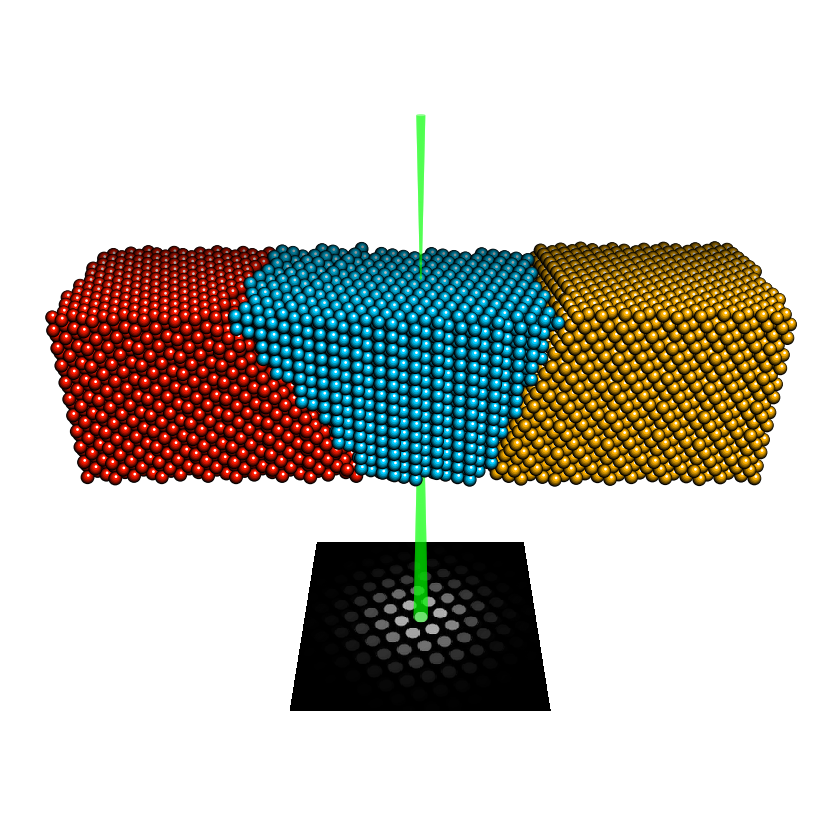

In [16]:
# Testing our final plotting function
fig,ax = plot_scene(
    xyz_id,
    probe_xy = (0,0),
)

And there you have it!  We can now draw this figure programmatically.  

We can now simply loop through a range of probe positions, and automatically compute and draw all of the elements.  First let's just save one image:

In [17]:
fig.savefig('schematic_03.png')

### Exercise 3 - Draw multiple probes.

In this exercise, you should extend the previous function to support mutiple probe positions.  The goal is to create something that looks like this image:

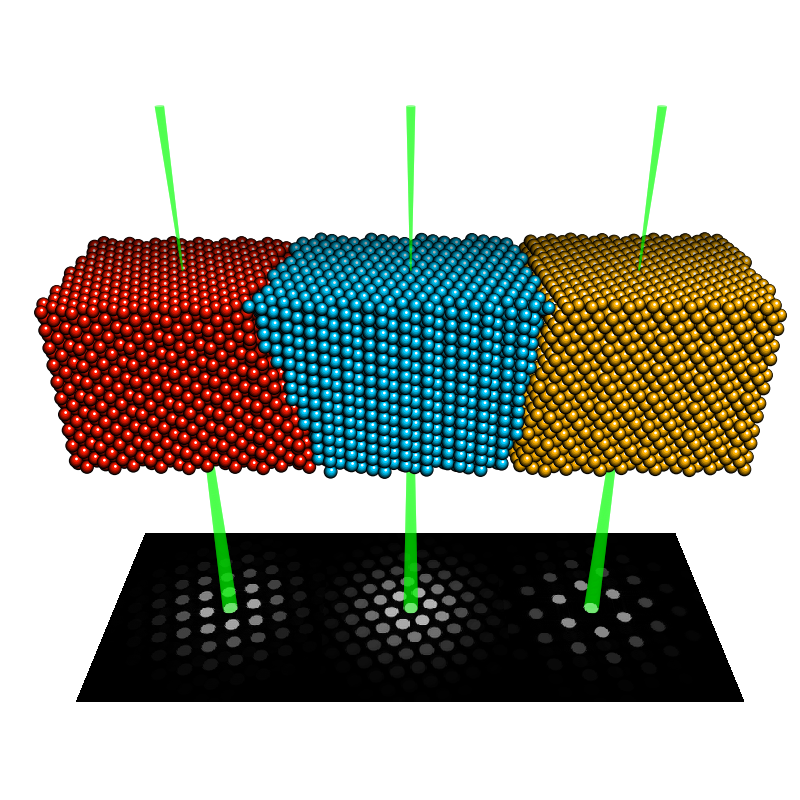

In [18]:
# Answer 3 -

# Render the movie

We could loop through probe positions, save the images, and then stitch them into a movie using ffmpeg. However it's also possible to skip writing the images and just directly pipe the outputs into a movie script, which we will demo here.

In [19]:
from subprocess import Popen, PIPE
import matplotlib

In [20]:
# Tweak these values to make smoother movies / more frames, or a faster render with less frames.

# These settings take ~8 mins, and might run out of RAM on colab
# fps = 60
# num_frames = 120
# These settings take ~4 mins, and should be ok for colab
fps = 30
num_frames = 60

file_output = 'diffraction_movie_02.mp4'

# Make sure file doesn't exist
!rm {file_output}

# init file writing
p = Popen(['ffmpeg', '-y', '-f',
           'image2pipe', '-i', '-', '-vcodec',
           'mpeg4', '-r', str(fps),
           '-q','4',
           file_output], stdin=PIPE)

probe_xy_all = np.vstack((
    np.hstack((
        np.linspace(-50,50,num_frames//2,endpoint=False),
        np.linspace(50,-50,num_frames//2,endpoint=False),
    )),
    np.zeros((1,num_frames))
)).T


for a0 in range(num_frames):
    fig,ax = plot_scene(
        xyz_id,
        probe_xy = probe_xy_all[a0],
    )

    fig.savefig(p.stdin, format='png')
    plt.close()

p.stdin.close()
p.wait()

0